In [1]:
import networkx as nx
import pyro.distributions as dist
import matplotlib.pylab as plt
import numpy as np
import torch
import sys
sys.path.append("/home/folzd/phd/compositions_mixtures_factors")

from code_generation import *

We can generate probabilistic programs in Pyro by composing building blocks of probabilistic models, 
and translating the resulting graph into pyro code.

Composing building blocks is formalized as performing graph operations on a starting graph.

A natural starting point for a graph is a single node corresponding to the observed variable(s).
Let's create such a starting graph, call the D variables 'X', which we observe N iid samples of.

In [2]:
G = nx.DiGraph()
name = 'X'
shape = 'D'
nodes = [
    (name,{'distribution':dist.Normal,'type':'obs','shape':shape,'event_dims':1})
]
G.add_nodes_from(nodes)
plate_attr = {
    name:{'plates':['N']},
}
nx.set_node_attributes(G, plate_attr)

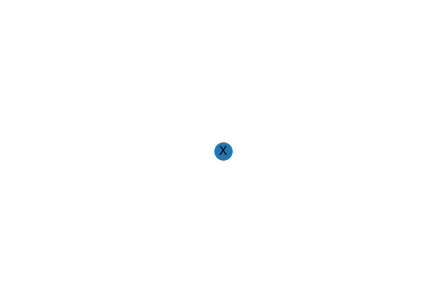

In [3]:
nx.draw(G, with_labels=True)

In [4]:
G.nodes['X']

{'distribution': pyro.distributions.torch.Normal,
 'type': 'obs',
 'shape': 'D',
 'event_dims': 1,
 'plates': ['N']}

Gaussian distributions are parameterized by a location and scale parameters. The simplest parametrization would be to let these parameters be known constants.

In [5]:
def parametrize_Normal(G, name):
    """
    Add loc and scale param nodes going into a Normal node
    """
    shape = G.nodes[name]['shape']
    type = 'latent'
    nodes = [
        (name+'_loc',{'type':'param','shape':shape}),
        (name+'_scale',{'type':'param','shape':shape,'constraint':'positive'})
    ]
    edges = [
        (name+'_loc',name,{'type':'param','param':'loc'}),
        (name+'_scale',name,{'type':'param','param':'scale'})
    ]
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    return G

In [6]:
G = parametrize_Normal(G, 'X')

/home/folzd/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/folzd/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


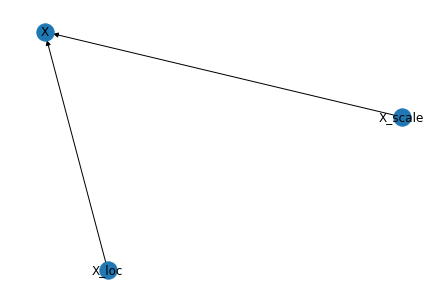

In [7]:
nx.draw(G, with_labels=True)

In factor models, the location parameter is replaced by a sum of 

1) a zero-mean product of the factors and loadings, and 

2) a mean.

To that end, we'll have a graph operation that replaces a node by a sum of nodes, which are given as input.

In [8]:
def sum_node(G, name, *term_nodes):
    """
    Adds an 'torch.add' node.
    Assumes nodes exist in graph.
    """
    assert len(term_nodes) > 1
    nodes = []
    edges = []
    for node in term_nodes:
        assert node in G
        edges.append((node,name,{'type':'arg'}))

    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    G.add_node(name,**{'type':'function', 'function':torch.add, 'args':('p',)*len(term_nodes)})

    return G

Now that we have a sum node, let's make the ops that create the terms.
The mean node is another Gaussian, parameterized by a loc and scale.

In [9]:
def add_Normal_node(G, name, shape = None):
    if name in G:
        shape = G.nodes[name]['shape']
    elif shape is None:
        raise Exception(f'''{name} isn't a node in the graph, to create a new node, provide a shape (e.g. 'D')''')

    G.add_node(name,**{'distribution':dist.Normal,'type':'latent','shape':shape,'event_dims':len(shape)})
    parametrize_Normal(G, name)
    return G

In [10]:
def add_factorization(G, name_product = 'Wz', name_loadings = 'W', name_factors = 'z'):
    nodes = [
        (name_product,{'type':'function', 'function':torch.matmul, 'args':('p','t')}),
        (name_factors,{'type':'param','shape':'K','plates':'N'}),
        (name_loadings,{'type':'param','shape':'DK'})
    ]
    edges = [
        (name_factors,name_product,{'type':'arg'}),
        (name_loadings,name_product,{'type':'arg'})
    ]
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G

In [11]:
add_factorization(G, 'Wz','W','z')

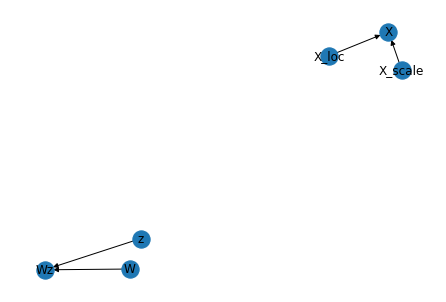

In [12]:
nx.draw(G, with_labels=True)

In [13]:
add_Normal_node(G, 'loc', 'D')

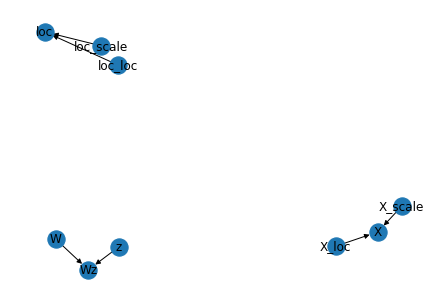

In [14]:
nx.draw(G, with_labels=True)

In [15]:
sum_node(G, 'X_loc', 'Wz', 'loc')

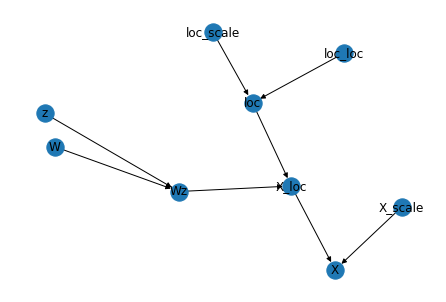

In [16]:
nx.draw(G, with_labels=True)

In [17]:
G.nodes['W']

{'type': 'param', 'shape': 'DK'}

We could let W and z be parameters and learn point estimates by maximum likelihood. But let's instead put priors on W and z, and learn the posterior distributions over these variables.

In [18]:
add_Normal_node(G, 'z')

In [19]:
G.nodes['z']

{'type': 'latent',
 'shape': 'K',
 'plates': 'N',
 'distribution': pyro.distributions.torch.Normal,
 'event_dims': 1}

In [20]:
add_Normal_node(G, 'W')

In [21]:
G.nodes['W']

{'type': 'latent',
 'shape': 'DK',
 'distribution': pyro.distributions.torch.Normal,
 'event_dims': 2}

In [22]:
G.nodes['X_scale']

{'type': 'param', 'shape': 'D', 'constraint': 'positive'}

If we wanted to leave X_scale as it is, a hyperparameter, we could. But let's put a prior on it as well. For that, we need another op.

In [23]:
def add_LogNormal_node(G, name):
    G.add_node(name,**{'distribution':dist.LogNormal,'type':'latent','shape':'D','event_dims':1})
    # the log normal is parameterized the same as the normal, so we can reuse that
    parametrize_Normal(G, name)
    return G

In [24]:
add_LogNormal_node(G, 'X_scale')

In [25]:
G.nodes['X_scale']

{'type': 'latent',
 'shape': 'D',
 'constraint': 'positive',
 'distribution': pyro.distributions.torch.LogNormal,
 'event_dims': 1}

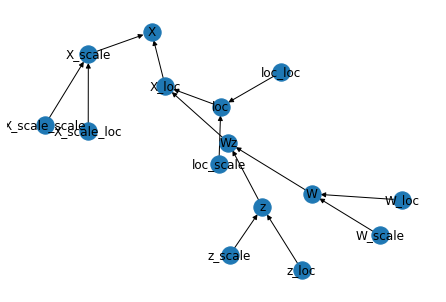

In [26]:
nx.draw(G, with_labels=True)

Just one more thing - during inference, the optimizer might try to set X_scale to such a small number that it causes numerical issues. To avoid that, we add "jitter", a small number, to the scale parameter. In order to do that, we modify the sum_node function to take direct arguments, such as numbers.

In [27]:
def sum_node(G, name, *terms):
    """
    Adds an 'torch.add' node.
    Assumes terms are nodes that exist in graph, or else direct arguments for the sum
    """
    assert len(terms) > 1
    nodes = []
    edges = []
    args = []
    for term in terms:
        if term in G:
            edges.append((term,name,{'type':'arg'}))
            args.append('p')
        else:
            args.append(term)

    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    G.add_node(name,**{'type':'function', 'function':torch.add, 'args':tuple(args)})

    return G

In [28]:
sum_node(G, 'X_scale_jitter', 'X_scale', Num(n=0.0001))
G.remove_edge('X_scale','X')
G.add_edge('X_scale_jitter','X', param = 'scale')

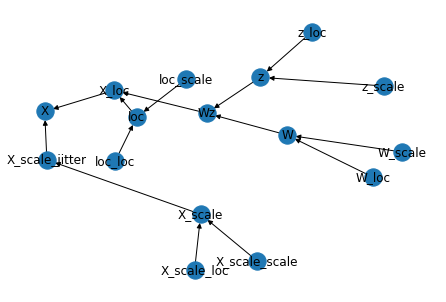

In [29]:
nx.draw(G, with_labels=True)

In [30]:
generate_Model_class(G)

Created model DAGmodel in model.py
